In [126]:
image = "G2_FOV1_checkpoint00.tif"#"./G2_FOV2_checkpoint03.tif"

import tifffile as tiff
img = tiff.imread(image)
img.shape

(50, 2054, 2456)

In [127]:
import numpy as np
imarray = np.array(img)
imarray

array([[[ 96, 160,  96, ..., 112, 128, 176],
        [128, 128, 160, ...,  96, 144, 128],
        [128, 112, 128, ..., 112, 128, 128],
        ...,
        [112,  96, 128, ..., 112,  96, 144],
        [144, 160, 160, ..., 112, 160, 144],
        [160, 112, 112, ..., 144, 112,  96]],

       [[128, 176, 128, ..., 112, 112, 112],
        [160, 112, 128, ...,  96, 144, 128],
        [144, 112, 112, ..., 112, 128, 128],
        ...,
        [ 96,  80, 128, ..., 160, 160, 112],
        [128, 144, 160, ..., 128, 176, 144],
        [160, 128, 128, ..., 144, 144,  96]],

       [[128, 112, 112, ...,  96, 144, 144],
        [128, 128, 112, ..., 144, 160, 112],
        [144, 144, 128, ..., 128, 112, 128],
        ...,
        [112, 160, 176, ..., 144, 112, 144],
        [160, 144, 144, ..., 128, 176, 112],
        [ 96, 112, 160, ..., 112, 112, 112]],

       ...,

       [[128, 144, 112, ..., 160, 128, 112],
        [112, 144,  96, ..., 128, 112, 144],
        [144,  96, 112, ..., 112, 144, 128

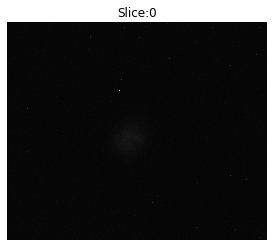

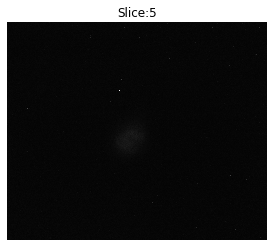

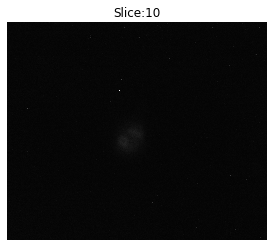

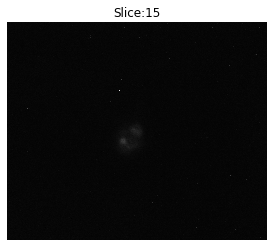

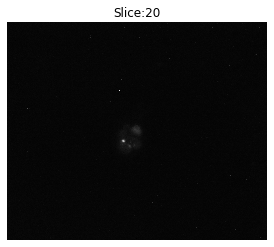

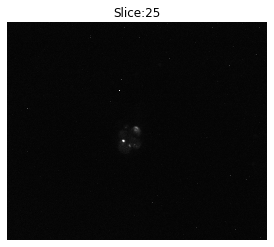

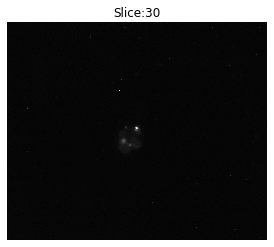

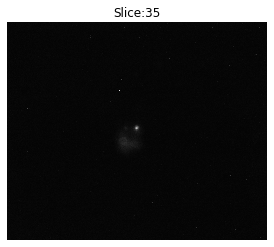

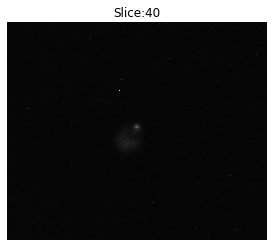

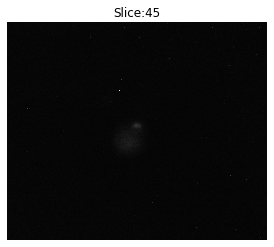

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(0,img.shape[0],int(img.shape[0]/10)):
    plt.figure()
    plt.imshow(img[_],cmap='gray', interpolation='nearest', vmin=0, vmax=5000)
    plt.title("Slice:{}".format(_))
    plt.axis('off')

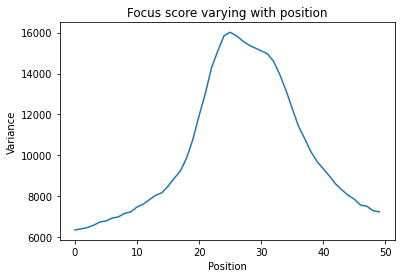

(50,)

In [129]:
#CREDIT:  sourtin/igem15-sw 
def low_res_score(IMAGE):

    def dwt(X, h1 = np.array([-1, 2, 6, 2, -1])/8 , h2 = np.array([-1, 2 -1])/4):
        """ 
        From 3rd year engineering project SF2
        DWT Discrete Wavelet Transform 
        Y = dwt(X, h1, h2) returns a 1-level 2-D discrete wavelet
        transform of X.
        
        If filters h1 and h2 are given, then they are used, 
        otherwise the LeGall filter pair are used.
        """
        m = X.shape[0] # no: of rows in image X
        n = X.shape[1] # no: of columns in image X
        Y = np.zeros((m,n))
        #print('Output image is of shape ',Y.shape)

        n2 = int(n/2)
        t = np.array(range(n2))
        #print('Editing this part of Y: ',Y[:,t].shape)
        #print(X.shape, h1.shape)
        
        Y[:,t] = rowdec(X, h1)
        Y[:,t+n2] = rowdec(X, h2)

        X = Y.T
        m2 = int(m/2)
        t = np.array(range(m2))
        # print(Y[t,:].shape)
        # print(X.shape)
        Y[t,:] = rowdec(X, h1).T
        Y[t+m2, :] = rowdec(X, h2).T
        return Y
        
    def rowdec(X, h):
        """"
        ROWDEC Decimate rows of a matrix
        Y = ROWDEC(X, H) Filters the rows of image X using H, and
        decimates them by a factor of 2.
        If length(H) is odd, each output sample is aligned with the first of
        each pair of input samples.
        If length(H) is even, each output sample is aligned with the mid point
        of each pair of input samples.
        """
        c = X.shape[1]
        r = X.shape[0]
        m = h.size
        m2 = int(m/2)
          
        if np.remainder(m,2)>0:
            # Odd h: symmetrically extend indices without repeating end samples.
            xe = np.array([x for y in [range(m2, 0, -1), range(c), range(c-2,c-m2-2, -1)]  for x in y])
        else:
            # Even h: symmetrically extend with repeat of end samples.
            xe = np.array([x for y in [range(m2,-1,-1), range(c+1), range(c-1,c-m2-2,-1)] for x in y])
        
        t = np.array(range(0, c-1, 2))
       
        Y = np.zeros((r, t.size))
        # Loop for each term in h.
        for i in range(m):
            Y = Y + h[i] * X[:,xe[t+i]];
            
        return Y

    def nleveldwt(X, N = 3):
        """ N level DWT of image
        Returns an array of the smaller resolution images
        """
        #print('N = ', N)
        Xs = [X]
        if N > 0:
            h, w = X.shape[:2]
            Xs += nleveldwt( dwt(X)[:h//2, :w//2], N-1)
        return Xs
        
    def focus_score(X):
        """ Focus score is the sum of the squared values of the low resolution images.
        """
        score = 0
        for i in X:
            i += 1
            score += np.var(i)
        return score   
     
    return focus_score(nleveldwt(IMAGE))



def plot_score(imgs,points = 10):
    score = []
    #f.move_motor()
    
    for i in imgs:
        #score.append(focus_score(i))
        score.append(low_res_score(i))
        #print(score)
        
    plt.plot(range(len(score)),score)
    plt.ylabel('Variance')
    plt.xlabel('Position')
    plt.title('Focus score varying with position')
    plt.show()    
    return np.array(score)

score = plot_score(img)
score.shape

In [130]:
def gaussian_fitting(z , f):
    """Fit the autofocus function data according to the equation 16.5 in the 
        textbook : 'Microscope Image Processing' by Q.Wu et al'
        z_max = gaussian_fitting((z1, z2, z3), (f1, f2 f3))
        where z1, z2 , z3 are points where the autofocus functions 
        values f1, f2, f3 are measured """
        
    z1 = z[0];z2 = z[1];z3 = z[2];    
    f1 = f[0];f2 = f[1];f3 = f[2];
    
    B = (np.log(f2) - np.log(f1))/(np.log(f3) - np.log(f2))
    
    if (z3 - z2)==(z2 - z1):
        return 0.5 * (B * (z3 + z2) - (z2 + z1))/(B-1)
    else:
        return 0.5 * (B * (z3**2 - z2**2) - (z2**2 - z1**2))/(B * (z3 - z2) - (z2 - z1))

gauss = gaussian_fitting((0,24,49),(score[0],score[24],score[49]))

gauss

25.44143732194326

10184.016575831556 3255.081807824551
16018.569898159267


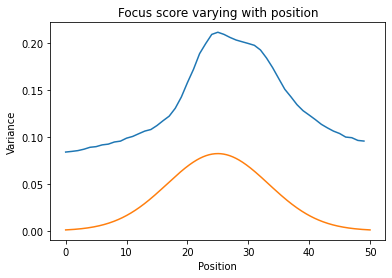

In [131]:
from scipy.stats import norm
def gaussian_fitting2(score):
    mean, std = norm.fit(score)
    return mean, std

gauss2_mean, gauss2_std = gaussian_fitting2(score)

print(gauss2_mean, gauss2_std)

x = np.linspace(gauss2_mean - 3*gauss2_std, gauss2_mean + 3*gauss2_std, 500)
xi = np.linspace(0,50,500)
print(np.max(score))

plt.plot(range(len(score)),score/np.linalg.norm(score))
plt.plot(xi, norm.pdf(x,loc=gauss2_mean, scale=gauss2_std)/np.linalg.norm(norm.pdf(x,loc=gauss2_mean, scale=gauss2_std)))
plt.ylabel('Variance')
plt.xlabel('Position')
plt.title('Focus score varying with position')
plt.show()   

maximum: 27.766237811491635 0.9788021308943625


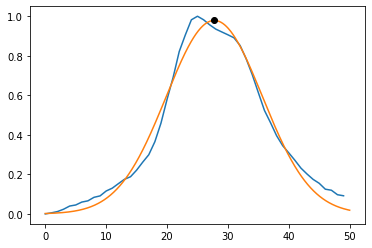

In [132]:
from scipy.optimize import curve_fit, minimize_scalar
#%matplotlib qt
%matplotlib inline
def f(x, p1, p2, p3):
    return p3/(np.sqrt(2.*np.pi)*p2)*np.exp(-np.power((x - p1)/p2, 2.)/2) 
xi = range(score.shape[0])

score2 = score - np.min(score)
score2 = score2/np.max(score2)
p0 = (25, 16, 0.1) # guess perameters 
plt.plot(xi,score2)
popt, pcov = curve_fit(f, xi, score2, p0)


# find the peak
fm = lambda xi: -f(xi, *popt)
r = minimize_scalar(fm, bounds=(1, 5))
print("maximum:", r["x"], f(r["x"], *popt))  #maximum: 2.99846874275 18.3928199902

x_curve = np.linspace(0, score2.shape[0], 500)
plt.plot(x_curve, f(x_curve, *popt))
plt.plot(r['x'], f(r['x'], *popt), 'ko')
plt.show()

In [133]:
max_score = np.max(score)
max_index = np.where(score == max_score)[0][0]
print("Max Score: {}".format(max_score))
print("Index of max focus Value: {}".format(max_index))

Max Score: 16018.569898159267
Index of max focus Value: 25


(-0.5, 2455.5, 2053.5, -0.5)

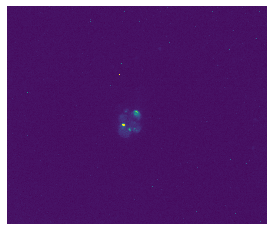

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt
plt.figure()
plt.imshow(img[max_index],interpolation='nearest', vmin=0, vmax=3000)
plt.axis('off')

(-0.5, 2455.5, 2053.5, -0.5)

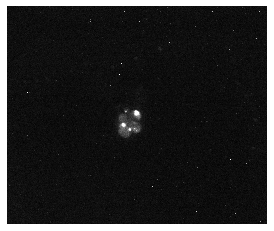

In [156]:
import cv2

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=0.1):
    gray = image.astype(np.uint16)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[65533],[0,65334])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

%matplotlib inline
#%matplotlib qt
index = int(r['x'])

img_adj = automatic_brightness_and_contrast(img[index])

plt.figure()
plt.imshow(img_adj[0],cmap='gray', interpolation='nearest')
plt.axis('off')